In [1]:
# 모델 정의 - WCNN_scale=2_insize=1_lr=0.001_patch=64_lastlayer

import os
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import *
import torch
import math
from os.path import join
import torch.utils.data as data
import numpy as np
from os import listdir
from os.path import join
from PIL import Image, ImageOps
import random
from random import randrange
from math import sqrt
from torchsummary import summary

'''
1. Channel_weighted_Conv
   어떤 '한개의' filter 에 대해, 
   입력 [r^2, N, N] 인 feature map 의 각 channel 의 conv. 결과를 순차적으로 mapping 한 [1, rN, rN] 크기의 feature map 생성하고,
   생성한 feature map 에 rxr inner filtering 을 적용한 [1, N, N] 크기의 결과를 출력하는 함수 
'''
class Channel_weighted_Conv(nn.Module):
  def __init__(self, input_size, kernel_size, stride=1, bias=True):
    super(Channel_weighted_Conv, self).__init__()
    self.input_size = input_size 
    # input_size = r^2

    self.conv = torch.nn.Conv2d(1, 1, kernel_size, stride, padding=int((kernel_size-1)/2), bias=bias)
    # 입력 feature map [batch, r^2, N, N]에서 [batch, i, N, N] 을 입력으로 받아 1 개의 feature map 출력
    # 출력이 [batch, i, N, N] 가 되게 하기 위해 padding = int((kernel_size-1)/2)
    self.PS =  nn.PixelShuffle (upscale_factor = int(math.sqrt(input_size)))
    # upscale_factor = r
    self.inner_conv = torch.nn.Conv2d(1, 1, kernel_size=int(math.sqrt(input_size)), stride=int(math.sqrt(input_size)), padding=0, bias=bias)

    '''
    apply 함수로 initialization 하기 힘들기 때문에 class 내에서 initialization 을 수행하도록 함
    '''
    for m in self.modules():
        # 이 class 에서 정의한 self.(변수)[인스턴스 변수] 목록 (conv, PS, inner_conv) 불러오기 
            classname = m.__class__.__name__
            # 불러온 module의 class 이름
            if classname.find('Conv2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            # Conv2d Layer 라면 He 방법으로 해당 Layer 의 weight 들을 초기화, bias 가 True 면 bias 를 0 으로 초기화
            elif classname.find('ConvTranspose2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
           # ConvTranspose2d Layer 라면 He 방법으로 해당 Layer 의 weight 들을 초기화, bias 가 True 면 bias 를 0 으로 초기화

  def forward(self, x):
    s = self.conv(x[:, 0:1, :, :])

    for i in range(1, self.input_size):
      m = self.conv(x[:, i:i+1, :, :])
      s = torch.cat([s, m], dim=1)
      
    # s.shape = [batch, r^2, N, N]
    # s = 입력 feature map의 각 channel에 대해 한개의 filter 와의 단순 convolution 결과 feature map
    
    ps = self.PS(s)
    # ps.shape = [batch, 1, rN, rN]
    # ps = 한 filter에 대해 입력 feature map 의 각 channel 가중치를 학습하기 전 feature map

    out = self.inner_conv(ps)
    # out.shape = [batch, 1, N, N]
    # out = 가중치를 학습하고 난 후 필터링 결과
    return out

'''
2. WCNN_block 
   기존의 Conv2d 와 같은 입력을 받아, 각 Channel 의 가중치 (inner_filter) 를 학습하는 과정을 추가하여
   입력과 동일한 크기의 output_size 개 만큼의 feature map 을 출력하는 New Conv2d layer
'''
class WCNN_block(nn.Module):
  def __init__(self, input_size, output_size, kernel_size):
    super(WCNN_block, self).__init__()
    self.filters = [0]*output_size

    '''
    여기서 filter 갯수(=output_size)만큼 Channel_weighted_Conv 을 list 형태로 담고,
    '''
    self.filters = nn.ModuleList([Channel_weighted_Conv(input_size, kernel_size, stride=1, bias=True) for _ in range(0, output_size)])
    self.filter_num = output_size
  
  def forward(self, x):
    '''
    여기서 각 Channel_weighted_Conv에 x(입력) 를 대입하고 나온 출력을 concatenation 해 준다.
    -> ModuleList 는 list 안의 각 Module 을 하나씩 접근 할 수 있게 해 줌
    '''
    out = self.filters[0](x)
    for i in range(1, self.filter_num):
      filtering = self.filters[i](x)
      out = torch.cat([out, filtering], dim=1)
    # out.shape = [batch, K, N, N]
    # out = 각 filter 들의 WCNN 결과의 concatenation
    return out

'''
3. ConvBlock
'''
class ConvBlock(nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3, stride=1, padding=1, bias=True, activation='relu', norm=None):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=bias)

        self.norm = norm
        if self.norm =='batch':
            self.bn = torch.nn.BatchNorm2d(output_size)
        elif self.norm == 'instance':
            self.bn = torch.nn.InstanceNorm2d(output_size)
        
        # self.bn : Conv Layer 출력에서 normalization 을 Instance 로 할지 Batch 로 할지 선택
        
        self.activation = activation
        if self.activation == 'relu':
            self.act = torch.nn.ReLU(True)
        elif self.activation == 'prelu':
            self.act = torch.nn.PReLU()
        elif self.activation == 'lrelu':
            self.act = torch.nn.LeakyReLU(0.2, True)
        elif self.activation == 'tanh':
            self.act = torch.nn.Tanh()
        elif self.activation == 'sigmoid':
            self.act = torch.nn.Sigmoid()
        
        # self.act : Conv Layer 출력 Activation Function 선택

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            # Conv2d Layer 라면 He 방법으로 해당 Layer 의 weight 들을 초기화, bias 가 True 면 bias 를 0 으로 초기화
            elif classname.find('ConvTranspose2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
           # ConvTranspose2d Layer 라면 He 방법으로 해당 Layer 의 weight 들을 초기화, bias 가 True 면 bias 를 0 으로 초기화
        
    def forward(self, x):
        if self.norm is not None:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)

        if self.activation is not None:
            return self.act(out)
        else:
            return out

'''
4. WCNN
'''
class WCNN(nn.Module):
    def __init__(self):
        super(WCNN, self).__init__()
        
        '''
        1. layer2 만을 WCNN_block 으로 바꿈
        2. WCNN_block 의 input_size = r^2 이어야 하는 것을 유의함
        '''
        self.layer1 = ConvBlock(3, 64, kernel_size=9, stride=1, padding=4, activation='relu', norm=None)
        self.layer2 = nn.Sequential(
            WCNN_block(input_size=64, output_size=16, kernel_size=1),
            nn.ReLU(),
        )
        # WCNN_block 의 Kernel_size = 홀수 여야 출력이미지의 size 가 입력과 같아진다
        self.layer3 = WCNN_block(input_size=16, output_size=3, kernel_size=5)
        

    def forward(self, x):
        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        y = self.layer3(f2)
        
        return y
print('finish')


finish


In [14]:
# 모델의 각 layer 의 weight 를 확인

import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from google.colab import drive


drive.mount('/content/gdrive')

'''
1. GPU 설정 및 parameter print
'''
gpus_list = range(1)
cudnn.benchmark = True

cuda = True
if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

model = WCNN()

'''
4. GPU 사용 여부 및 pretrained model 사용 여부 설정
'''
if cuda:
    model = model.cuda(gpus_list[0])
    model = torch.nn.DataParallel(model, device_ids=gpus_list)

'''
print(model)
weights = list(model.parameters())
print(len(weights))
print(weights[0].size())  # conv1의 .weight
'''
for name, param in model.named_parameters(): 
  # model.named_parameters 는 model 각 계층의 이름과 weights 를 반환 함
  print(f'name:{name}') 
  print(type(param)) 
  print(f'param.shape:{param.shape}') 
  print(f'param.requries_grad:{param.requires_grad}') 
  # 해당 weights 가 학습 가능한지 아닌지에 대한 boolean
  print('=====')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
name:module.layer1.conv.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 3, 9, 9])
param.requries_grad:True
=====
name:module.layer1.conv.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====
name:module.layer2.0.filters.0.conv.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([1, 1, 1, 1])
param.requries_grad:True
=====
name:module.layer2.0.filters.0.conv.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([1])
param.requries_grad:True
=====
name:module.layer2.0.filters.0.inner_conv.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([1, 1, 8, 8])
param.requries_grad:True
=====
name:module.layer2.0.filters.0.inner_conv.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([1])
param.requries_grad:True
=====
name:module.

In [15]:
# model 에서 각각의 filter 가 학습하는 channel 간의 가중치를 확인하기 위해 inner_conv 의 filter weight 와 bias 만 뽑아냄

for name, param in model.named_parameters():
  if 'inner_conv.weight' in name:
    print(f'name:{name}')
    print(f'param.shape:{param.shape}')
    print('=====')
  if 'inner_conv.bias' in name:
    print(f'name:{name}')
    print(f'param.shape:{param.shape}')
    print('=====')

input = torch.randn(1, 1, 32, 32)
model.layer2(input)

name:module.layer2.0.filters.0.inner_conv.weight
param.shape:torch.Size([1, 1, 8, 8])
=====
name:module.layer2.0.filters.0.inner_conv.bias
param.shape:torch.Size([1])
=====
name:module.layer2.0.filters.1.inner_conv.weight
param.shape:torch.Size([1, 1, 8, 8])
=====
name:module.layer2.0.filters.1.inner_conv.bias
param.shape:torch.Size([1])
=====
name:module.layer2.0.filters.2.inner_conv.weight
param.shape:torch.Size([1, 1, 8, 8])
=====
name:module.layer2.0.filters.2.inner_conv.bias
param.shape:torch.Size([1])
=====
name:module.layer2.0.filters.3.inner_conv.weight
param.shape:torch.Size([1, 1, 8, 8])
=====
name:module.layer2.0.filters.3.inner_conv.bias
param.shape:torch.Size([1])
=====
name:module.layer2.0.filters.4.inner_conv.weight
param.shape:torch.Size([1, 1, 8, 8])
=====
name:module.layer2.0.filters.4.inner_conv.bias
param.shape:torch.Size([1])
=====
name:module.layer2.0.filters.5.inner_conv.weight
param.shape:torch.Size([1, 1, 8, 8])
=====
name:module.layer2.0.filters.5.inner_conv.b

AttributeError: ignored

In [3]:
# 데이터 전처리 & 사용자 정의 data

from __future__ import print_function
import argparse

import os
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import *
import torch
import math
from os.path import join
import torch.utils.data as data
import numpy as np
from os import listdir
from os.path import join
from PIL import Image, ImageOps, ImageFilter
import random
from random import randrange
from math import sqrt

'''
1. filename 에 .png, .jpg, .jpeg 중 하나라도 있으면 True 를 반환하는 함수
'''
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

'''
2. PIL 을 이용하여 filepath에서 이미지를 불러오고 RGB 로 convert 하여 반환하는 함수
'''
def load_img(filepath):
    img = Image.open(filepath).convert('RGB')
    return img

'''
3. PIL 을 이용하여 이미지를 Bicubic 으로 scale 만큼 High Resolution 으로 만드는 함수
'''
def rescale_img(img_in, scale):
    size_in = img_in.size
    # size_in = img_in 의 (width, height) tuple
    new_size_in = tuple([int(x * scale) for x in size_in])
    # new_size_in = (width * scale, height * scale)
    img_in = img_in.resize(new_size_in, resample=Image.BICUBIC)
    return img_in

'''
4. img_tar = load_img 함수를 이용하여 index 번째 image 를 RGB 로 불러온 이미지 
   img_in = target 으로 불러온 이미지를 Bicubic 으로 downscale 한 이미지 -> (사용할 일 없음)
   img_bic = rescale_img 함수로 input 을 다시 같은 비율로 upscale 한 이미지

   training 에는 img_tar, img_bic 을 사용할 것이고, 이들 이미지 임의의 영역을
   upscale_factor*n x upscale_factor*n 크기로 잘라 이미지 크기를 같게 만들어 줌
   
   잘린 이미지는 같은 random point 에서 시작하여 잘리므로 이미지가 나타내는 임의의 영역이 같음
'''
def get_patch(img_in, img_tar, img_bic, patch_size, scale, ix=-1, iy=-1):
    (ih, iw) = img_in.size
    (th, tw) = (scale * ih, scale * iw)

    patch_mult = scale #if len(scale) > 1 else 1
    tp = patch_mult * patch_size
    # tp = upscale_factor*n (n = patch_size)
    ip = tp // scale
    # ip = n (n = patch_size)
    
    if ix == -1:
        ix = random.randrange(0, iw - ip + 1)
    if iy == -1:
        iy = random.randrange(0, ih - ip + 1)

    (tx, ty) = (scale * ix, scale * iy)

    img_in = img_in.crop((iy,ix,iy + ip, ix + ip))
    # 원본이미지 임의의 영역을 n x n 크기로 자름
    img_tar = img_tar.crop((ty,tx,ty + tp, tx + tp))
    # downscale 한 이미지 임의의 영역을 upscale_factor*n x upscale_factor*n 크기로 자름
    img_bic = img_bic.crop((ty,tx,ty + tp, tx + tp))
    # upscale 한 이미지 임의의 영역을 upscale_factor*n x upscale_factor*n 크기로 자름            
    info_patch = {
        'ix': ix, 'iy': iy, 'ip': ip, 'tx': tx, 'ty': ty, 'tp': tp}
    # info_patch 에는 어떤 크기로 crop 했는지에 대한 정보가 있음
    return img_in, img_tar, img_bic, info_patch

'''
5. 이미지데이터 증강(augmentation)
'''
def augment(img_in, img_tar, img_bic, flip_h=True, rot=True):
    info_aug = {'flip_h': False, 'flip_v': False, 'trans': False}
    
    if random.random() < 0.5 and flip_h:
        img_in = ImageOps.flip(img_in)
        img_tar = ImageOps.flip(img_tar)
        img_bic = ImageOps.flip(img_bic)
        info_aug['flip_h'] = True
    # 50%의 확률로, flip_h = True 면 img_in, img_tar, img_bic 을 모두 flip

    if rot:
        if random.random() < 0.5:
            img_in = ImageOps.mirror(img_in)
            img_tar = ImageOps.mirror(img_tar)
            img_bic = ImageOps.mirror(img_bic)
            info_aug['flip_v'] = True
        if random.random() < 0.5:
            img_in = img_in.rotate(180)
            img_tar = img_tar.rotate(180)
            img_bic = img_bic.rotate(180)
            info_aug['trans'] = True
    # 50%의 확률로, rot = True 면 img_in, img_tar, img_bic 을 모두 mirror & 180도 rotate
    
    return img_in, img_tar, img_bic, info_aug
    # info_aug = 출력된 이미지에 어떤 preprocessing 을 했는지 알려줌
    
'''
6. PIL 이미지나 ndarray 이미지를 Tensor로 바꾸어주는 함수
   -> ToTensor 함수 사용시 이미지 pixel 값은 0~255 에서 0~1 로 바뀜
'''
def transform():
    return Compose([ToTensor(),])

'''
7.사용자 정의 data 로드 - Training Data 
'''        
class DatasetFromFolder(data.Dataset):
    '''
    def __init__(self, index) 에서는 필요한 변수를 선언 하고 'data 경로' 를 load 한다
    '''
    def __init__(self, image_dir, patch_size, upscale_factor, data_augmentation, transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]
        # self.image_filenames = image_dir 에 있는 모든 이미지의 경로 list
        self.patch_size = patch_size
        self.upscale_factor = upscale_factor
        self.transform = transform
        self.data_augmentation = data_augmentation
    '''
    def __getitem__(self, index) 에서는 index 번째 data를 return 하도록 코드를 짠다
    '''
    def __getitem__(self, index):
        target = load_img(self.image_filenames[index])
        # target = load_img 함수를 이용하여 index 번째 image 를 RGB 로 불러온 이미지
        input = target.resize((int(target.size[0]/self.upscale_factor),int(target.size[1]/self.upscale_factor)), Image.BICUBIC) 
        # input = target 으로 불러온 이미지를 Bicubic 으로 downscale 한 이미지
        bicubic = rescale_img(input, self.upscale_factor)
        # bicubic = rescale_img 함수로 input 을 다시 같은 비율로 upscale 한 이미지
        
        input, target, bicubic, _ = get_patch(input,target,bicubic,self.patch_size, self.upscale_factor)
        # input, target, bicubic 이미지를 (upscale_factor*patch_size x upscale_factor*patch_size) 로 crop
        
        if self.data_augmentation:
            input, target, bicubic, _ = augment(input, target, bicubic)
        # data_augmentation = True 라면, 세 이미지를 augment 함수로 증강, img_aug 는 필요 없음
        
        if self.transform:
            input = self.transform(input)
            bicubic = self.transform(bicubic)
            target = self.transform(target)
        # self.transform = True 라면, 세 이미지를 PIL image 에서 Tensor로 바꾸어 줌
        return input, target, bicubic
    '''
    def __len__(self) 에서는 data의 len을 return 하도록 코드를 짠다
    '''
    def __len__(self):
        return len(self.image_filenames)
    
'''
8.사용자 정의 data 로드 - Test Data 
   -> file 이름까지 사용자 정의 데이터화 시킴
   -> get_patch 함수를 사용하지 않기 때문에, SRCNN 의 입력으로 (원본 이미지 xscale) 된 이미지가 들어감
'''
class DatasetFromFolderEval(data.Dataset):
    def __init__(self, lr_dir, upscale_factor, transform=None):
        super(DatasetFromFolderEval, self).__init__()
        self.image_filenames = [join(lr_dir, x) for x in listdir(lr_dir) if is_image_file(x)]
        self.upscale_factor = upscale_factor
        self.transform = transform

    def __getitem__(self, index):
        target = load_img(self.image_filenames[index])
        # target = load_img 함수를 이용하여 index 번째 image 를 RGB 로 불러온 이미지
        _, file = os.path.split(self.image_filenames[index])
        # file = 이미지 경로 list 에서 file 이름만 잘라 냄

        input = target.resize((int(target.size[0]/self.upscale_factor),int(target.size[1]/self.upscale_factor)), Image.BICUBIC) 
        # input = target 으로 불러온 이미지를 Bicubic 으로 downscale 한 이미지
        bicubic = rescale_img(input, self.upscale_factor)
        # bicubic = rescale_img 함수로 input 을 다시 같은 비율로 upscale 한 이미지
        
        if self.transform:
            input = self.transform(input)
            bicubic = self.transform(bicubic)
            target = self.transform(target)
         # self.transform = True 라면, 세 이미지를 PIL image 에서 Tensor로 바꾸어 줌
        
        return input, bicubic, target, file
        # file 이름까지 return
      
    def __len__(self):
        return len(self.image_filenames)
'''
9. Training Data 불러오기
'''
def get_training_set(data_dir, hr, upscale_factor, patch_size, data_augmentation):
    hr_dir = join(data_dir, hr)
    return DatasetFromFolder(hr_dir,patch_size, upscale_factor, data_augmentation,
                             transform=transform())
'''
10. Test Data 불러오기
'''
def get_eval_set(lr_dir, upscale_factor):
    return DatasetFromFolderEval(lr_dir, upscale_factor,
                             transform=transform())

print('finish')

finish


In [12]:
# layer information

# 각 filter 의 channel_weights_graph 출력 - layer3

from __future__ import print_function
import argparse

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from functools import reduce
from math import log10
import torch
import numpy as np
import matplotlib.pyplot as plt

# from scipy.misc import imsave
import scipy.io as sio
import time
import cv2
import easydict
from google.colab import drive
drive.mount('/content/gdrive')


opt = easydict.EasyDict({ 
    "testBatchSize": 1,     # 이미지를 1개씩불러옴 
    "upscale_factor": 2,    # Upscale 정도
    "input_channel": 3,     # WCNN model 입력의 Channel (color = 3, gray = 1)

    "model_type": "WCNN",         # 모델이름
    
    "input_dir":"/content/gdrive/MyDrive/졸업논문/data_800개/test",  # test dataset 불러올위치
    "test_dataset": "low_color_test",                             # test에 사용할 dataset 종류
    "output": "/content/gdrive/MyDrive/졸업논문/졸업논문/scale=2/insize=1_lr=0.001_patch=64_lastlayer/results/", # 결과영상 저장위치
    "model_type": "WCNN",
    "model": "/content/gdrive/MyDrive/졸업논문/졸업논문/scale=2/insize=1_lr=0.001_patch=64_lastlayer/weights/WCNN_epoch_100.pth",
    # test에 사용할 weight 불러올 파일 경로
    
    "pretrained": True,
    "data_augmentation": False,
    "gpu_mode": True,
    "threads": 0, 
    "gpus": 1 # 사용할 gpu 번호
    })

'''
1. GPU 설정 및 parameter print
'''
gpus_list = range(opt.gpus)
cudnn.benchmark = True
print(opt)

cuda = opt.gpu_mode
if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

'''
2. Test Data 로드
'''
print('===> Loading datasets')
test_set = get_eval_set(os.path.join(opt.input_dir,opt.test_dataset), opt.upscale_factor)
testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.testBatchSize, shuffle=False)

'''
3. Criterion 정의 
  -> MSE loss 사용
'''
criterion = nn.MSELoss() 

'''
4. NN 정의
'''
model = WCNN()

'''
5. pretrained model 및 GPU 사용 여부 설정
'''
if cuda:
    model = model.cuda(gpus_list[0])
    model = torch.nn.DataParallel(model, device_ids=gpus_list)
    criterion = criterion.cuda(gpus_list[0])
if opt.pretrained:
    model_name = os.path.join(opt.model)
    checkpoint = torch.load(model_name)

    model.load_state_dict(checkpoint['model_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    print('Pre-trained SR model is loaded.')
    # pretrained model 불러오기
    
for layer in model.modules():
  print(layer)

print('finish')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
{'testBatchSize': 1, 'upscale_factor': 2, 'input_channel': 3, 'model_type': 'WCNN', 'input_dir': '/content/gdrive/MyDrive/졸업논문/data_800개/test', 'test_dataset': 'low_color_test', 'output': '/content/gdrive/MyDrive/졸업논문/졸업논문/scale=2/insize=1_lr=0.001_patch=64_lastlayer/results/', 'model': '/content/gdrive/MyDrive/졸업논문/졸업논문/scale=2/insize=1_lr=0.001_patch=64_lastlayer/weights/WCNN_epoch_100.pth', 'pretrained': True, 'data_augmentation': False, 'gpu_mode': True, 'threads': 0, 'gpus': 1}
===> Loading datasets


RuntimeError: ignored

(64,)
(64,)
(64,)


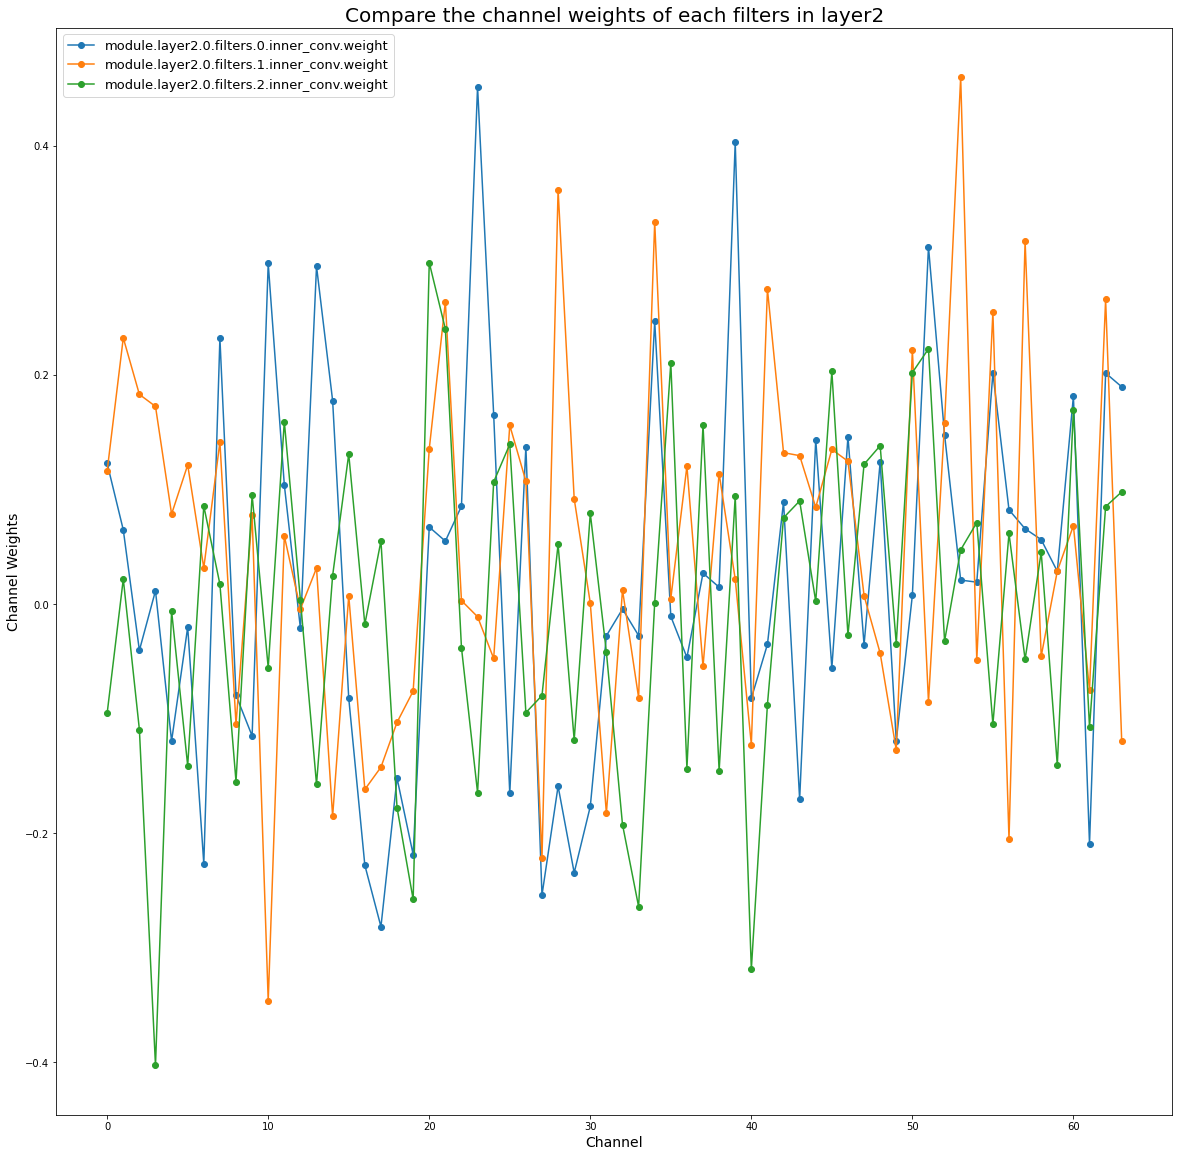

In [10]:
# 각 filter 의 channel_weights_graph 출력 - layer2

import torch
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

n=0
# 그래프를 그릴 filter 갯수 제한
for name, param in model.named_parameters():
  if n < 3:
    if 'layer2.0.filters' in name: 
      if 'inner_conv.weight' in name:
        param = param.detach().cpu().numpy()
        # tensor 를 numpy array 로 바꾸어줌 
        param = param.flatten()
        filter_number = list(range(0, len(param)))
        ax.plot(filter_number, param, marker='o',label=name) ## 선그래프 생성
        n += 1
  else:
    break

plt.title('Compare the channel weights of each filters in layer2',fontsize=20) ## 타이틀 설정
plt.ylabel('Channel Weights', fontsize=14) # y 축 이름 설정
plt.xlabel('Channel', fontsize=14) # x 축 이름 설정
plt.legend(fontsize=13) # 범례
plt.show()